<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Scaling ColPALI (VLM) Retrieval 

This notebook demonstrates how to represent [ColPali](https://huggingface.co/vidore/colpali) in Vespa
and to scale to large collections. Also see the blog post: [Scaling ColPali to billions of PDFs with Vespa](https://blog.vespa.ai/scaling-colpali-to-billions/)

Consider following the [ColQWen2](https://pyvespa.readthedocs.io/en/latest/examples/pdf-retrieval-with-ColQwen2-vlm_Vespa-cloud.html) notebook instead as it
use a better model with improved performance (Both accuracy and speed).

ColPali is a powerful visual language model that can generate embeddings for images (screenshots of PDF pages) and text queries.

In this notebook, we will use ColPali to generate embeddings for images of PDF _pages_ and store the embeddings in Vespa. 
We will also store the base64 encoded image of the PDF page and meta data like title and url. 

We demonstrate how to retrieve relevant pages for a query using the embeddings generated by ColPali.

The TLDR of this notebook:

- Generate an image per PDF page using [pdf2image](https://pypi.org/project/pdf2image/) 
and also extract the text using [pypdf](https://pypdf.readthedocs.io/en/stable/user/extract-text.html). 
- For each page image, use ColPali to obtain the visual multi-vector embeddings

Then we store visual embeddings in Vespa as a `int8` tensor, where we use a binary compression technique
to reduce the storage footprint by 32x compared to float representations. See [Scaling ColPali to billions of PDFs with Vespa](https://blog.vespa.ai/scaling-colpali-to-billions/)
for details on binarization and using hamming distance for retrieval.

During retrieval time, we use the same ColPali model to generate embeddings for the query and then use Vespa's `nearestNeighbor` query to retrieve the most similar documents
per query vector token, using binary representation with hamming distance. Then we re-rank the results in two phases:

- In the 0-phase we use hamming distance to retrieve the k closest pages per query token vector representation, this is expressed by using multiple nearestNeighbor query operators in Vespa.
- The nearestNeighbor operators exposes pages to the first-phase ranking function, which uses an approximate MaxSim using inverted hamming distance insted of cosine similarity. This is done to reduce the number of pages that are re-ranked in the second phase.
- In the second phase, we perform the full MaxSim operation, using float representations of the embeddings to re-rank the top-k pages from the first phase.

This allows us to scale ColPali to very large collections of PDF pages, while still providing accurate and fast retrieval.

Let us get started. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vespa-engine/pyvespa/blob/master/docs/sphinx/source/examples/simplified-retrieval-with-colpali-vlm_Vespa-cloud.ipynb)


Install dependencies: 

Note that the python pdf2image package requires poppler-utils, see other installation options [here](https://pdf2image.readthedocs.io/en/latest/installation.html#installing-poppler).

In [1]:
#!sudo apt-get install poppler-utils -y

Now install the required python packages:

In [2]:
#!pip3 install colpali-engine==0.3.1 vidore_benchmark==4.0.0 pdf2image pypdf==5.0.1 pyvespa vespacli requests numpy

In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from io import BytesIO

from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from vidore_benchmark.utils.image_utils import scale_image, get_base64_image
from torch.amp import autocast

/Users/thomas/Repos/sample-apps/visual-retrieval-colpali/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the model

This requires that the HF_TOKEN environment variable is set as the underlaying PaliGemma model is hosted on Hugging Face 
and has a [restricive licence](https://ai.google.dev/gemma/terms) that requires authentication.

Choose the right device to run the model.

In [4]:
device = get_torch_device()
if device == "cuda":
    dtype = torch.bfloat16
else:
    dtype = torch.float32

Load the model and the processor.

In [5]:
model_name = "vidore/colpali-v1.2"
model = ColPali.from_pretrained(
    model_name, torch_dtype=torch.float32, device_map=device
).eval()
processor = ColPaliProcessor.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


### Working with pdfs

We need to convert a PDF to an array of images. One image per page. 
We use the `pdf2image` library for this task. Secondary, we also extract the text contents of the PDF using `pypdf`. 

NOTE: This step requires that you have `poppler` installed on your system. Read more in [pdf2image](https://pdf2image.readthedocs.io/en/latest/installation.html) docs.

In [6]:
import requests
from pdf2image import convert_from_path
from pypdf import PdfReader


def download_pdf(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        raise Exception(f"Failed to download PDF: Status code {response.status_code}")


def get_pdf_images(pdf_url):
    # Download the PDF
    pdf_file = download_pdf(pdf_url)
    # Save the PDF temporarily to disk (pdf2image requires a file path)
    temp_file = "temp.pdf"
    with open(temp_file, "wb") as f:
        f.write(pdf_file.read())
    reader = PdfReader(temp_file)
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path(temp_file)
    assert len(images) == len(page_texts)
    return (images, page_texts)

We define a few sample PDFs to work with. The PDFs are discovered from [this url](https://www.conocophillips.com/company-reports-resources/sustainability-reporting/).

In [7]:
sample_pdfs = [
    {
        "title": "ConocoPhillips Sustainability Highlights - Nature (24-0976)",
        "url": "https://static.conocophillips.com/files/resources/24-0976-sustainability-highlights_nature.pdf",
    },
    {
        "title": "ConocoPhillips Managing Climate Related Risks",
        "url": "https://static.conocophillips.com/files/resources/conocophillips-2023-managing-climate-related-risks.pdf",
    },
    {
        "title": "ConocoPhillips 2023 Sustainability Report",
        "url": "https://static.conocophillips.com/files/resources/conocophillips-2023-sustainability-report.pdf",
    },
]

Now we can convert the PDFs to images and also extract the text content.

In [8]:
for pdf in sample_pdfs:
    page_images, page_texts = get_pdf_images(pdf["url"])

    pdf["images"] = page_images
    pdf["texts"] = page_texts

Let us look at the extracted image of the first PDF page. This is the document side input to ColPali, one image per page.

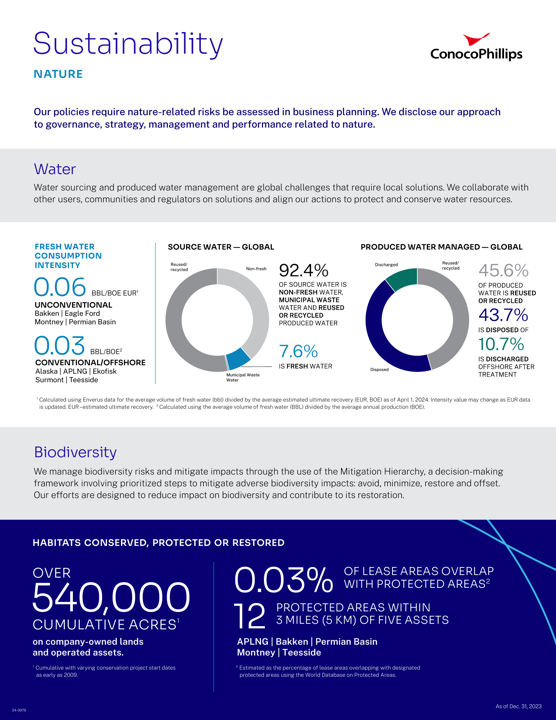

In [9]:
from IPython.display import display

display(scale_image(sample_pdfs[0]["images"][0], 720))

Let us also look at the extracted text content of the first PDF page. 

In [10]:
print(sample_pdfs[0]["texts"][0])

Water
Water sourcing and produced water management are global challenges that require local solutions. We collaborate with 
other users, communities and regulators on solutions and align our actions to protect and conserve water resources.
Biodiversity   
We manage biodiversity risks and mitigate impacts through the use of the Mitigation Hierarchy, a decision-making 
framework involving prioritized steps to mitigate adverse biodiversity impacts: avoid, minimize, restore and offset. 
Our efforts are designed to reduce impact on biodiversity and contribute to its restoration.Our policies require nature-related risks be assessed in business planning. We disclose our approach 
to governance, strategy, management and performance related to nature. NATURESustainability
23-1207HAB ITATS CONSE RVED, PROTECTED OR REST ORED
2 Estimated as the percentage of lease areas overlapping with designated 
protected areas using the World Database on Protected Areas.OVER 
540 ,000
CUMULATIVE ACRES1
 
1 Cum

Notice how the layout and order of the text is different from the image representation. Note that 

- The headlines NATURE and Sustainability have been combined into one word (NATURESustainability).
- The 0.03% has been converted to 0.03 and order is not preserved in the text representation.
- The data in the infographics is not represented in the text representation. For example the source water distribution in the infographics is not represented in the text representation.

Now we use the ColPali model to generate embeddings of the images.

In [12]:
for pdf in sample_pdfs:
    page_embeddings = []
    dataloader = DataLoader(
        pdf["images"],
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: processor.process_images(x),
    )
    for batch_doc in tqdm(dataloader):
        with torch.no_grad():
            with autocast(device_type=device):
                batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
                embeddings_doc = model(**batch_doc)
                page_embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))
    pdf["embeddings"] = page_embeddings

100%|██████████| 52/52 [03:51<00:00,  4.45s/it]


Now we are done with the document side embeddings, we now convert the embeddings to Vespa JSON format so we can store (and index) them in Vespa. 
Details in [Vespa JSON feed format doc](https://docs.vespa.ai/en/reference/document-json-format.html).

 
We use binary quantization (BQ) of the page level ColPali vector embeddings to reduce their size by 32x.

Read more about binarization of multi-vector representations in the [colbert blog post](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/). 

The binarization step maps 128 dimensional floats to 128 bits, or 16 bytes per vector. Reducing the size by 32x. On the [DocVQA benchmark](https://huggingface.co/datasets/vidore/docvqa_test_subsampled), binarization results in a small drop in ranking accuracy. 

In [22]:
import numpy as np

vespa_feed = []
for pdf in sample_pdfs:
    url = pdf["url"]
    title = pdf["title"]
    for page_number, (page_text, embedding, image) in enumerate(
        zip(pdf["texts"], pdf["embeddings"], pdf["images"])
    ):
        base_64_image = get_base64_image(scale_image(image, 640), add_url_prefix=False)
        embedding_dict = dict()
        for idx, patch_embedding in enumerate(embedding):
            binary_vector = (
                np.packbits(np.where(patch_embedding > 0, 1, 0))
                .astype(np.int8)
                .tobytes()
                .hex()
            )
            embedding_dict[idx] = binary_vector
        page = {
            "id": hash(url + str(page_number)),
            "fields": {
                "url": url,
                "title": title,
                "page_number": page_number,
                "image": base_64_image,
                "text": page_text,
                "embedding": embedding_dict,
            },
        }
        vespa_feed.append(page)

### Configure Vespa
[PyVespa](https://pyvespa.readthedocs.io/en/latest/) helps us build the [Vespa application package](https://docs.vespa.ai/en/application-packages.html).
A Vespa application package consists of configuration files, schemas, models, and code (plugins).

First, we define a [Vespa schema](https://docs.vespa.ai/en/schemas.html) with the fields we want to store and their type.

In [14]:
from vespa.package import Schema, Document, Field, FieldSet, HNSW

colpali_schema = Schema(
    name="pdf_page",
    document=Document(
        fields=[
            Field(
                name="id", type="string", indexing=["summary", "index"], match=["word"]
            ),
            Field(name="url", type="string", indexing=["summary", "index"]),
            Field(
                name="title",
                type="string",
                indexing=["summary", "index"],
                match=["text"],
                index="enable-bm25",
            ),
            Field(name="page_number", type="int", indexing=["summary", "attribute"]),
            Field(name="image", type="raw", indexing=["summary"]),
            Field(
                name="text",
                type="string",
                indexing=["index"],
                match=["text"],
                index="enable-bm25",
            ),
            Field(
                name="embedding",
                type="tensor<int8>(patch{}, v[16])",
                indexing=[
                    "attribute",
                    "index",
                ],  # adds HNSW index for candidate retrieval.
                ann=HNSW(
                    distance_metric="hamming",
                    max_links_per_node=32,
                    neighbors_to_explore_at_insert=400,
                ),
            ),
        ]
    ),
    fieldsets=[FieldSet(name="default", fields=["title", "text"])],
)

Notice the `embedding` field which is a tensor field with the type `tensor<int8>(patch{}, v[16])`. 
This is the field we use to represent the patch embeddings from ColPali. 

We also enable [HNSW indexing](https://docs.vespa.ai/en/approximate-nn-hnsw.html) 
for this field to enable fast nearest neighbor search which is used for candidate retrieval. 

We use [binary hamming distance](https://docs.vespa.ai/en/nearest-neighbor-search.html#using-binary-embeddings-with-hamming-distance) 
as an approximation of the cosine similarity. Hamming distance is a good approximation
for binary representations, and it is much faster to compute than cosine similarity/dot product. 

The `embedding` field is an example of a mixed tensor where we combine one mapped (sparse) dimensions with a dense dimension. 

Read more in [Tensor guide](https://docs.vespa.ai/en/tensor-user-guide.html). We also enable [BM25](https://docs.vespa.ai/en/reference/bm25.html) for the `title` and `texts` fields. Notice that the `image` field use type `raw` to store the binary image data, encoded with as a base64 string. 

Create the Vespa [application package](https://docs.vespa.ai/en/application-packages): 

In [15]:
from vespa.package import ApplicationPackage

vespa_app_name = "visionrag5"
vespa_application_package = ApplicationPackage(
    name=vespa_app_name, schema=[colpali_schema]
)

Now we define how we want to rank the pages for a query. We use Vespa's support for [BM25](https://docs.vespa.ai/en/reference/bm25.html) for the text, and 
late interaction with Max Sim for the image embeddings. 

This means that we use the the text representations as a candidate retrieval phase,  then we use the ColPALI embeddings with MaxSim 
to rerank the pages. 

In [16]:
from vespa.package import RankProfile, Function, FirstPhaseRanking, SecondPhaseRanking

colpali_profile = RankProfile(
    name="default",
    inputs=[("query(qt)", "tensor<float>(querytoken{}, v[128])")],
    functions=[
        Function(
            name="max_sim",
            expression="""
                sum(
                    reduce(
                        sum(
                            query(qt) * unpack_bits(attribute(embedding)) , v
                        ),
                        max, patch
                    ),
                    querytoken
                )
            """,
        ),
        Function(name="bm25_score", expression="bm25(title) + bm25(text)"),
    ],
    first_phase=FirstPhaseRanking(expression="bm25_score"),
    second_phase=SecondPhaseRanking(expression="max_sim", rerank_count=100),
)
colpali_schema.add_rank_profile(colpali_profile)

The first phase uses a linear combination of BM25 scores for the text fields, and the second phase uses the MaxSim function with the image embeddings. Notice that Vespa supports a `unpack_bits` function to convert the 16 compressed binary vectors to 128-dimensional floats for the MaxSim function. The query input tensor is not compressed and using full float resolution.

### Deploy the application to Vespa Cloud

With the configured application, we can deploy it to [Vespa Cloud](https://cloud.vespa.ai/en/).

To deploy the application to Vespa Cloud we need to create a tenant in the Vespa Cloud:

Create a tenant at [console.vespa-cloud.com](https://console.vespa-cloud.com/) (unless you already have one).
This step requires a Google or GitHub account, and will start your [free trial](https://cloud.vespa.ai/en/free-trial).


In [17]:
from vespa.deployment import VespaCloud
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "vespa-team"

key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=vespa_app_name,
    key_content=key,  # Key is only used for CI/CD testing of this notebook. Can be removed if logging in interactively
    application_package=vespa_application_package,
)

Setting application...
Running: vespa config set application vespa-team.visionrag5
Setting target cloud...
Running: vespa config set target cloud

Api-key found for control plane access. Using api-key.
Certificate and key not found in /Users/thomas/Repos/pyvespa/docs/sphinx/source/examples/.vespa or /Users/thomas/.vespa/vespa-team.visionrag5.default: Creating new cert/key pair with vespa CLI.
Generating certificate and key...
Running: vespa auth cert -N
Success: Certificate written to '/Users/thomas/.vespa/vespa-team.visionrag5.default/data-plane-public-cert.pem'
Success: Private key written to '/Users/thomas/.vespa/vespa-team.visionrag5.default/data-plane-private-key.pem'



Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes 2 minutes until the endpoint is up.


In [18]:
from vespa.application import Vespa

app: Vespa = vespa_cloud.deploy()

Deployment started in run 134 of dev-aws-us-east-1c for vespa-team.visionrag5. This may take a few minutes the first time.
INFO    [13:35:57]  Deploying platform version 8.449.13 and application dev build 105 for dev-aws-us-east-1c of default ...
INFO    [13:35:57]  Using CA signed certificate version 3
INFO    [13:35:57]  Using 1 nodes in container cluster 'visionrag5_container'
WARNING [13:35:58]  Auto-overriding validation which would be disallowed in production: certificate-removal: Data plane certificate(s) from cluster 'visionrag5_container' is removed (removed certificates: [CN=cloud.vespa.example]) This can cause client connection issues.. To allow this add <allow until='yyyy-mm-dd'>certificate-removal</allow> to validation-overrides.xml, see https://docs.vespa.ai/en/reference/validation-overrides.html
INFO    [13:35:58]  Using 1 nodes in container cluster 'visionrag5_container'
WARNING [13:35:59]  Auto-overriding validation which would be disallowed in production: certificate-

In [19]:
print("Number of PDF pages:", len(vespa_feed))

Number of PDF pages: 155


Index the documents in Vespa using the Vespa HTTP API. 

In [ ]:
from vespa.io import VespaResponse


def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print(
            f"Failed to feed document {id} with status code {response.status_code}: Reason {response.get_json()}"
        )


# Feed data into Vespa synchronously
app.feed_iterable(vespa_feed, schema="pdf_page", callback=callback)

### Querying Vespa

Ok, so now we have indexed the PDF pages in Vespa. Let us now obtain ColPali embeddings for a few text queries and 
use it during ranking of the indexed pdf pages. 

Now we can query Vespa with the text query and rerank the results using the ColPali embeddings.


In [34]:
queries = [
    "Percentage of non-fresh water as source?",
    "Policies related to nature risk?",
    "How much of produced water is recycled?",
]

Obtain the query embeddings using the ColPali model:

In [35]:
dataloader = DataLoader(
    queries,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: processor.process_queries(x),
)
qs = []
for batch_query in dataloader:
    with torch.no_grad():
        with autocast(device_type=device):
            batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
            embeddings_query = model(**batch_query)
            qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))

We create a simple routine to display the results. We render the image and the title of the retrieved page/document.


In [36]:
from IPython.display import display, HTML


def display_query_results(query, response, hits=5):
    query_time = response.json.get("timing", {}).get("searchtime", -1)
    query_time = round(query_time, 2)
    count = response.json.get("root", {}).get("fields", {}).get("totalCount", 0)
    html_content = f"<h3>Query text: '{query}', query time {query_time}s, count={count}, top results:</h3>"

    for i, hit in enumerate(response.hits[:hits]):
        title = hit["fields"]["title"]
        url = hit["fields"]["url"]
        page = hit["fields"]["page_number"]
        image = hit["fields"]["image"]
        score = hit["relevance"]

        html_content += f"<h4>PDF Result {i + 1}</h4>"
        html_content += f'<p><strong>Title:</strong> <a href="{url}">{title}</a>, page {page+1} with score {score:.2f}</p>'
        html_content += (
            f'<img src="data:image/png;base64,{image}" style="max-width:100%;">'
        )

    display(HTML(html_content))

Query Vespa with the queries and display the results, here we are using the `default` rank profile.

Note that we retrieve using textual representation with `userInput(@userQuery)`, this means that we use the BM25 ranking for the extracted text in the first ranking phase and then re-rank the top-k pages using the ColPali embeddings.

Later in this notebook we will use Vespa's support for approximate nearest neighbor search (`nearestNeighbor`) to retrieve directly using the ColPali embeddings.


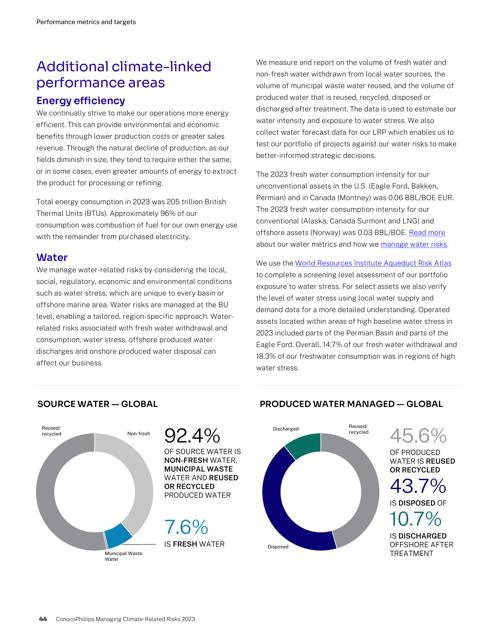
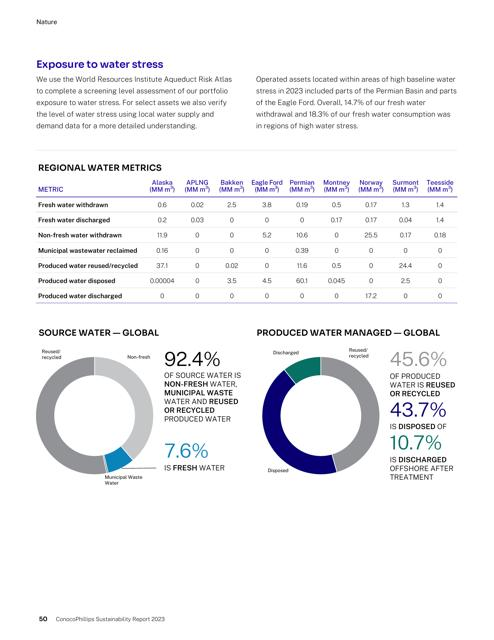
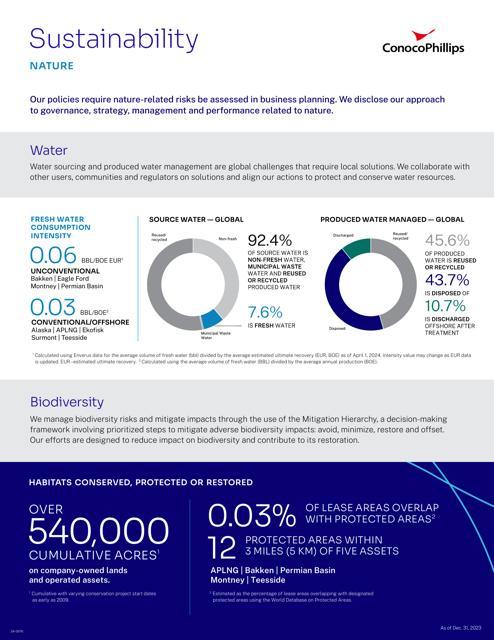


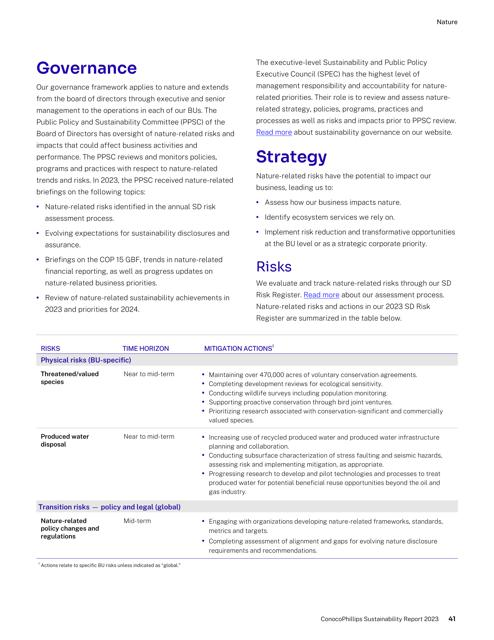
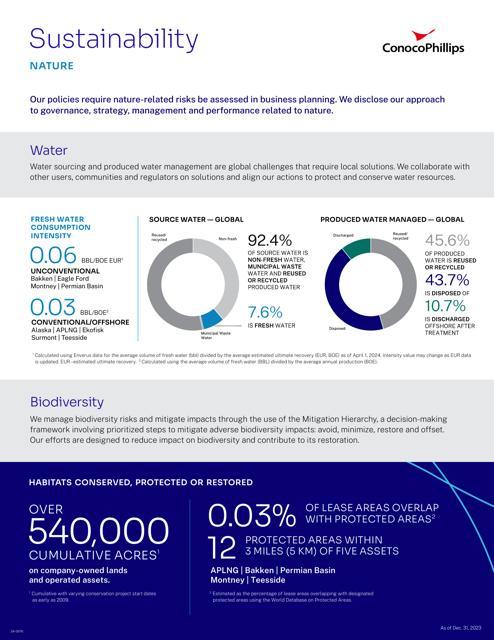
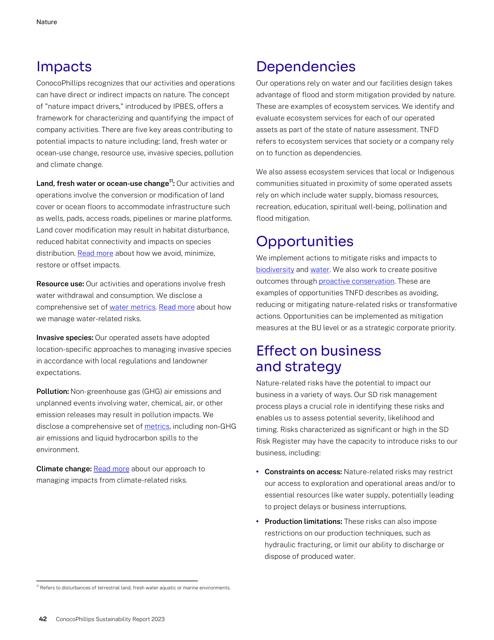


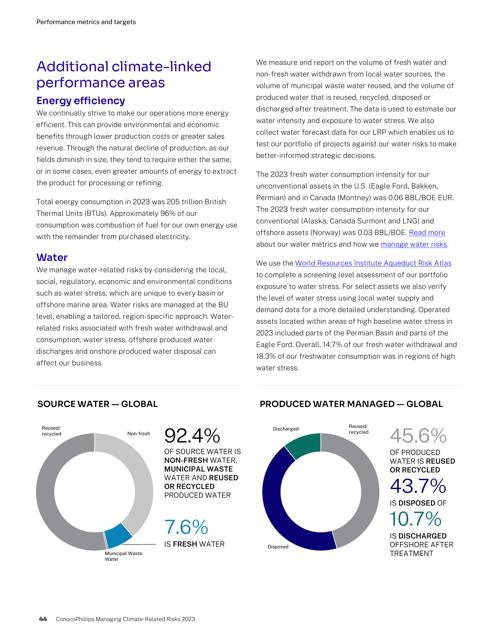
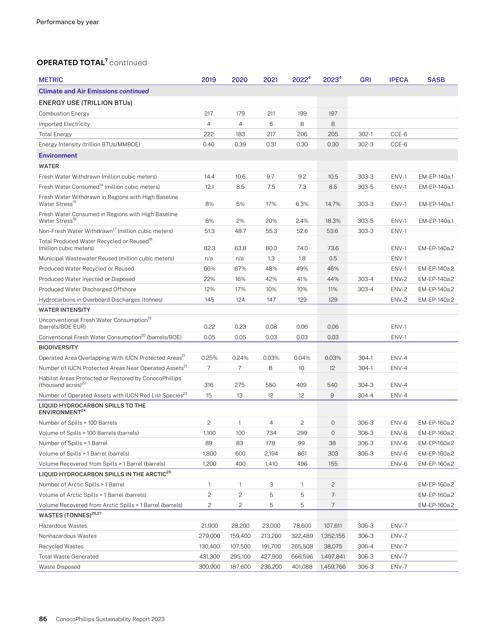
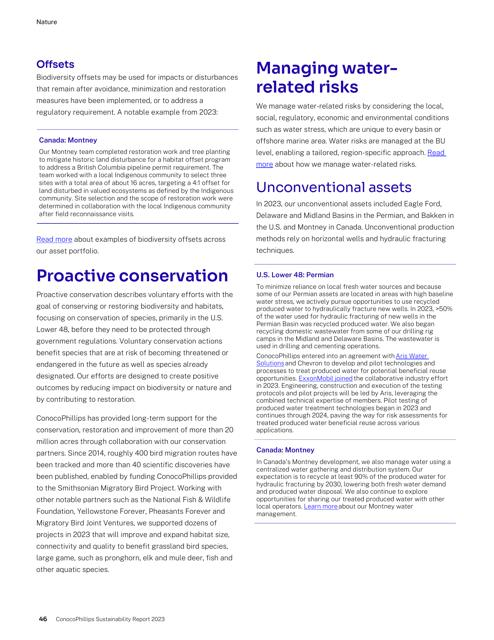

In [37]:
from vespa.io import VespaQueryResponse

async with app.asyncio(connections=1, timeout=120) as session:
    for idx, query in enumerate(queries):
        query_embedding = {k: v.tolist() for k, v in enumerate(qs[idx])}
        response: VespaQueryResponse = await session.query(
            yql="select title,url,image,page_number from pdf_page where userInput(@userQuery)",
            ranking="default",
            userQuery=query,
            timeout=120,
            hits=3,
            body={"input.query(qt)": query_embedding, "presentation.timing": True},
        )
        assert response.is_successful()
        display_query_results(query, response)

### Using nearestNeighbor for retrieval

In the above example, we used the ColPali embeddings in ranking, but using the text query for retrieval. 
This is a reasonable approach for text-heavy documents where the text representation is the most important and where ColPali embeddings are used to
re-rank the top-k documents from the text retrieval phase. 

In some cases, the ColPali embeddings are the most important and we want
to demonstrate how we can use HNSW indexing with binary hamming distance to retrieve the most similar pages to a query and
then have two steps of re-ranking using the ColPali embeddings. 

All the phases here are executed locally inside the Vespa content node(s) so that no vector data needs
to cross the network.

Let us add a new rank-profile to the schema, the `nearestNeighbor` operator takes a query tensor and a field tensor as argument and
we need to define the query tensors types in the rank-profile. 

In [38]:
from vespa.package import RankProfile, Function, FirstPhaseRanking, SecondPhaseRanking

input_query_tensors = []
MAX_QUERY_TERMS = 64
for i in range(MAX_QUERY_TERMS):
    input_query_tensors.append((f"query(rq{i})", "tensor<int8>(v[16])"))

input_query_tensors.append(("query(qt)", "tensor<float>(querytoken{}, v[128])"))
input_query_tensors.append(("query(qtb)", "tensor<int8>(querytoken{}, v[16])"))

colpali_retrieval_profile = RankProfile(
    name="retrieval-and-rerank",
    inputs=input_query_tensors,
    functions=[
        Function(
            name="max_sim",
            expression="""
                sum(
                    reduce(
                        sum(
                            query(qt) * unpack_bits(attribute(embedding)) , v
                        ),
                        max, patch
                    ),
                    querytoken
                )
            """,
        ),
        Function(
            name="max_sim_binary",
            expression="""
                sum(
                  reduce(
                    1/(1 + sum(
                        hamming(query(qtb), attribute(embedding)) ,v)
                    ),
                    max,
                    patch
                  ),
                  querytoken
                )
            """,
        ),
    ],
    first_phase=FirstPhaseRanking(expression="max_sim_binary"),
    second_phase=SecondPhaseRanking(expression="max_sim", rerank_count=10),
)
colpali_schema.add_rank_profile(colpali_retrieval_profile)

We define two functions, one for the first phase and one for the second phase. Instead of the float representations, we use the binary representations with inverted hamming distance in the first phase. Now, we need to re-deploy the application to Vespa Cloud.

In [39]:
from vespa.application import Vespa

app: Vespa = vespa_cloud.deploy()

Deployment started in run 2 of dev-aws-us-east-1c for vespa-team.visionrag5. This may take a few minutes the first time.
INFO    [13:49:53]  Deploying platform version 8.450.33 and application dev build 2 for dev-aws-us-east-1c of default ...
INFO    [13:49:53]  Using CA signed certificate version 3
INFO    [13:49:53]  Using 1 nodes in container cluster 'visionrag5_container'
INFO    [13:49:56]  Session 326369 for tenant 'vespa-team' prepared and activated.
INFO    [13:49:56]  ######## Details for all nodes ########
INFO    [13:49:56]  h105061a.dev.us-east-1c.aws.vespa-cloud.net: expected to be UP
INFO    [13:49:56]  --- platform vespa/cloud-tenant-rhel8:8.450.33
INFO    [13:49:56]  --- storagenode on port 19102 has config generation 326368, wanted is 326369
INFO    [13:49:56]  --- searchnode on port 19107 has config generation 326369, wanted is 326369
INFO    [13:49:56]  --- distributor on port 19111 has config generation 326368, wanted is 326369
INFO    [13:49:56]  --- metricsproxy-c

Now we can query Vespa with the text queries and use the `nearestNeighbor` operator to retrieve the most similar pages to the query and pass the different query tensors. 


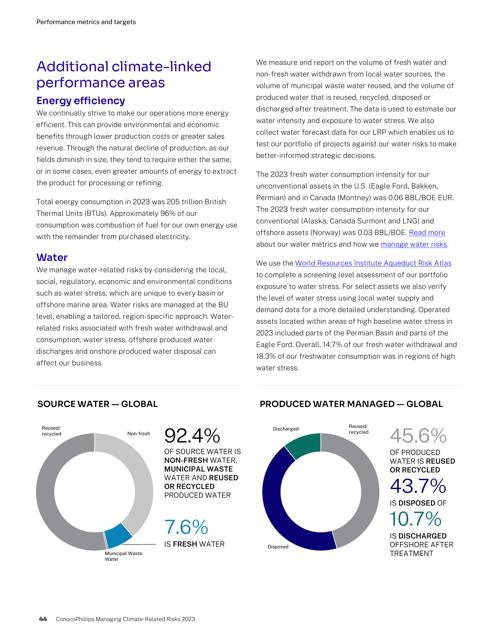
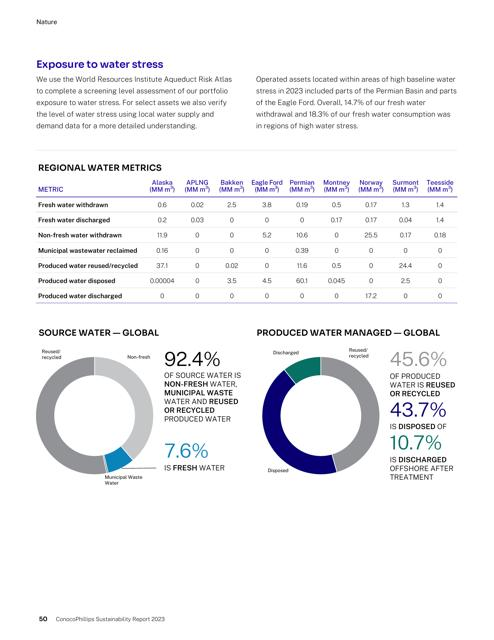
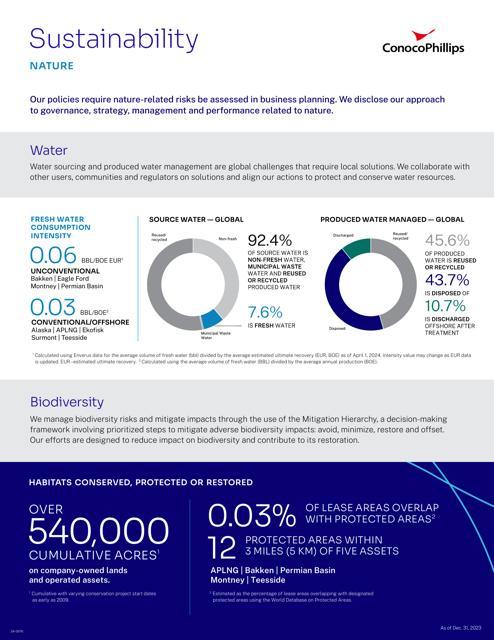


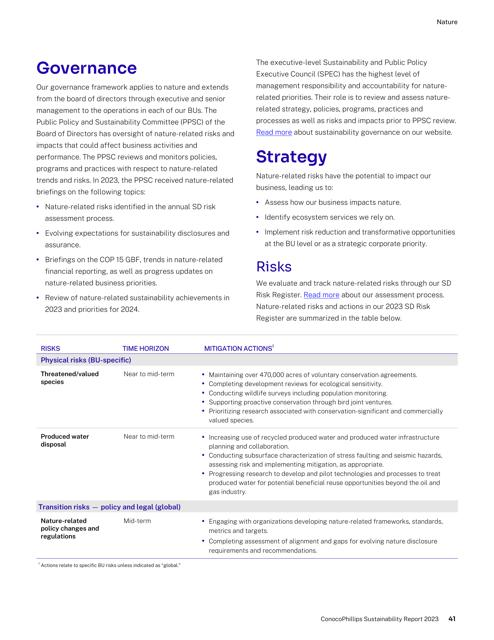
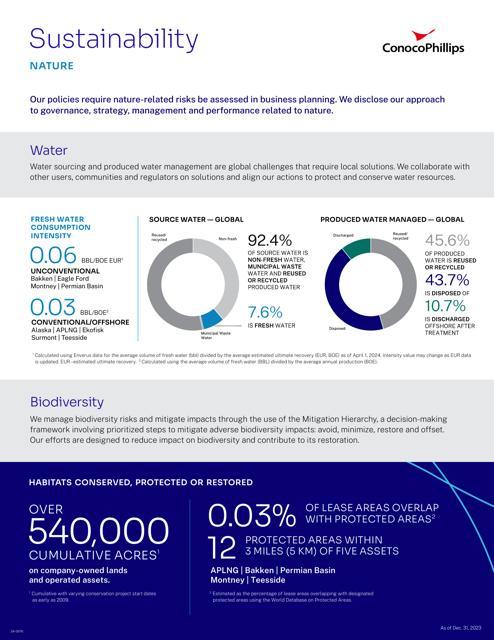
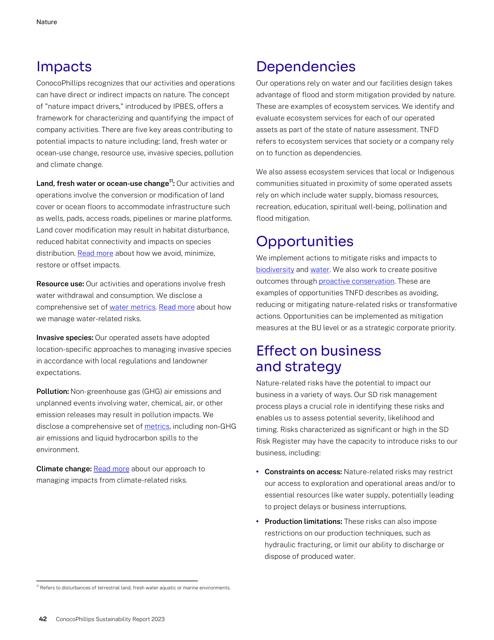


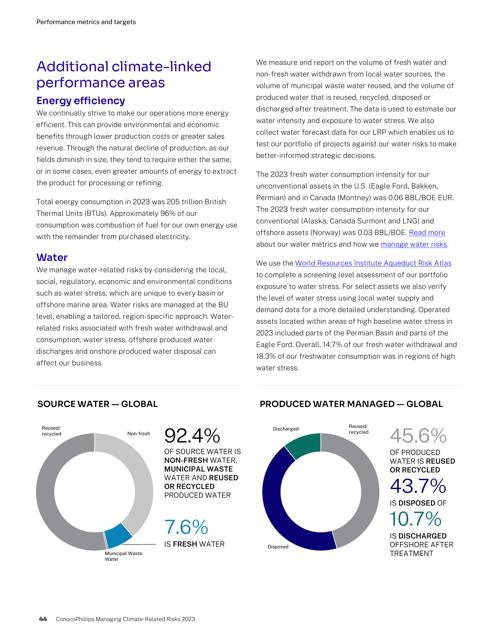
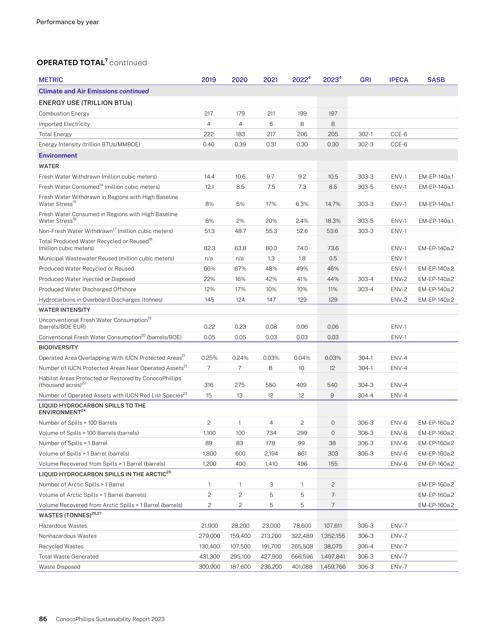
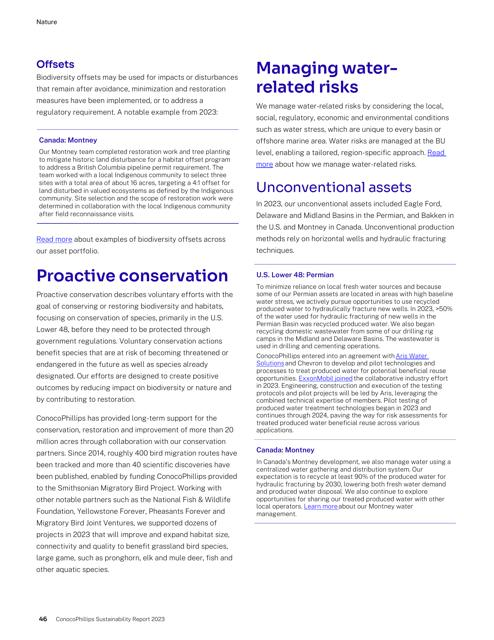

In [40]:
from vespa.io import VespaQueryResponse

target_hits_per_query_tensor = (
    20  # this is a hyper parameter that can be tuned for speed versus accuracy
)
async with app.asyncio(connections=1, timeout=180) as session:
    for idx, query in enumerate(queries):
        float_query_embedding = {k: v.tolist() for k, v in enumerate(qs[idx])}
        binary_query_embeddings = dict()
        for k, v in float_query_embedding.items():
            binary_query_embeddings[k] = (
                np.packbits(np.where(np.array(v) > 0, 1, 0)).astype(np.int8).tolist()
            )

        # The mixed tensors used in MaxSim calculations
        # We use both binary and float representations
        query_tensors = {
            "input.query(qtb)": binary_query_embeddings,
            "input.query(qt)": float_query_embedding,
        }
        # The query tensors used in the nearest neighbor calculations
        for i in range(0, len(binary_query_embeddings)):
            query_tensors[f"input.query(rq{i})"] = binary_query_embeddings[i]
        nn = []
        for i in range(0, len(binary_query_embeddings)):
            nn.append(
                f"({{targetHits:{target_hits_per_query_tensor}}}nearestNeighbor(embedding,rq{i}))"
            )
        # We use a OR operator to combine the nearest neighbor operator
        nn = " OR ".join(nn)
        response: VespaQueryResponse = await session.query(
            yql=f"select title, url, image, page_number from pdf_page where {nn}",
            ranking="retrieval-and-rerank",
            timeout=120,
            hits=3,
            body={**query_tensors, "presentation.timing": True},
        )
        assert response.is_successful()
        display_query_results(query, response)

Depending on the scale, we can evaluate changing different number of targetHits per nearestNeighbor operator and the ranking depths in the two phases. We can also parallelize the ranking phases by using more threads per query request to reduce latency.

## Summary 

In this notebook, we have demonstrated how to represent ColPali in Vespa. We have generated embeddings for images of PDF pages using ColPali and stored the embeddings in Vespa using [mixed tensors](https://docs.vespa.ai/en/tensor-user-guide.html). 

We demonstrated how to store the base64 encoded image using the `raw` Vespa field type, plus meta data like title and url. 
We have demonstrated how to retrieve relevant pages for a query using the embeddings generated by ColPali. 

This notebook can be extended to include more complex ranking models, more complex queries, and more complex data structures, including metadata and other fields which can be filtered on or used for ranking.

## Cleanup

When this notebook is running in CI, we want to delete the application.

In [ ]:
if os.getenv("CI", "false") == "true":
    vespa_cloud.delete()

Deactivated vespa-team.visionrag5 in dev.aws-us-east-1c
Deleted instance vespa-team.visionrag5.default
